<a href="https://colab.research.google.com/github/sadehqaan/digit-handwrites-recognitions/blob/master/digit_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Digit recognition

In [0]:
from google.colab import files
!pip install -q kaggle

In [2]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!cp kaggle.json /root/.kaggle/

In [5]:
!kaggle competitions download -c digit-recognizer

 81% 59.0M/73.2M [00:00<00:00, 67.1MB/s]
100% 73.2M/73.2M [00:00<00:00, 100MB/s] 
 84% 41.0M/48.8M [00:00<00:00, 40.9MB/s]
100% 48.8M/48.8M [00:00<00:00, 65.9MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 36.8MB/s]


In [6]:
!ls

kaggle.json  sample_data  sample_submission.csv  test.csv  train.csv


In [0]:
import pandas as pd
from fastai.vision import *

In [0]:
#train = pd.read_csv('train.csv')

In [0]:
#train.head()

In [0]:
#y_train = train['label']

In [0]:
#x_train = train.iloc[:,1:].to_numpy() 

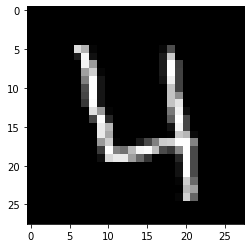

In [0]:
#plt.imshow(x_train[3].reshape((28,28)), cmap="gray")

In [0]:
# x_train,y_train = map(torch.tensor, (x_train,y_train))
# n,c = x_train.shape
# x_train.shape, y_train.min(), y_train.max()

(torch.Size([42000, 784]), tensor(0), tensor(9))

In [0]:
class MyDataset(TensorDataset):
    "Sample numpy array dataset"
    def __init__(self, x, y):
        self.x, self.y = x, y
        self.c = 10
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [0]:
from sklearn.model_selection import train_test_split

def createTensorDataSet(path):
  df = pd.read_csv(path)
  y = df['label'].to_numpy()
  x = df.iloc[:,1:].to_numpy()
  x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.03,random_state=42)
  x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
  train_ds = MyDataset(x_train, y_train)
  valid_ds = MyDataset(x_valid, y_valid)
  tfms = get_transforms(do_flip=False)
  data = ImageDataBunch.create(train_ds, valid_ds, bs=64)
  return data

In [0]:
#data = createTensorDataSet('train.csv')
tfms = get_transforms(do_flip=False)
df = pd.read_csv('train.csv')
data = ImageDataBunch.from_df('/root/', df,  size=26)

In [11]:
"data.show_batch(rows=3, figsize=(5,5))

AttributeError: ignored

In [0]:
doc(ImageList.from_folder)

In [0]:
class PixelImageItemList(ImageList):
    def open(self,fn):
        regex = re.compile(r'\d+')
        fn = re.findall(regex,fn)
        df = self.inner_df[self.inner_df.fn.values == int(fn[0])]
        df_fn = df[df.fn.values == int(fn[0])]
        img_pixel = df_fn.drop(labels=['label','fn'],axis=1).values
        img_pixel = img_pixel.reshape(28,28)
        img_pixel = np.stack((img_pixel,)*3,axis=-1)
        return vision.Image(pil2tensor(img_pixel,np.float32).div_(255))

In [23]:
df_train = pd.read_csv('train.csv')
df_train['fn'] = df_train.index
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,fn
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4


In [0]:
src = (PixelImageItemList.from_df(df_train,'.',cols='fn')
      .split_by_rand_pct()
      .label_from_df(cols='label'))

In [0]:
data = (src.transform(tfms=(rand_pad(padding=5,size=28,mode='zeros'),[]))
       .databunch(bs=64)
       .normalize(imagenet_stats))

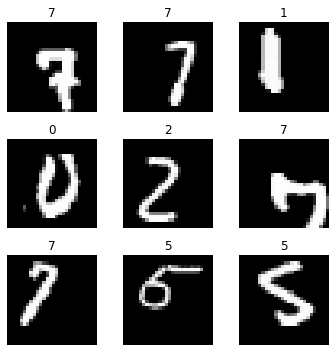

In [26]:
data.show_batch(rows=3, figsize=(5,5))

In [27]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 80.7MB/s]


In [28]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.919455,0.562027,0.812024,08:05
1,0.607424,0.379229,0.875595,08:08


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


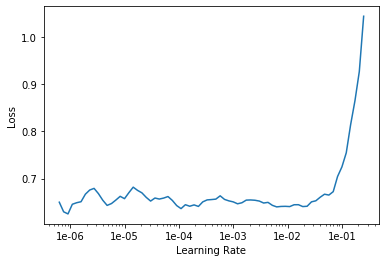

In [29]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze()

In [31]:
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.443199,0.255053,0.917500,14:57
1,0.311034,0.170903,0.944048,15:25
2,0.276270,0.155371,0.948690,15:22


In [0]:
class CustomImageItemList(ImageList):
    def open(self, fn):
        img = fn.reshape(28,28)
        img = np.stack((img,)*3, axis=-1) # convert to 3 channels
        return Image(pil2tensor(img, dtype=np.float32))

    @classmethod
    def from_csv_custom(cls, path:PathOrStr, csv_name:str, imgIdx:int=1, header:str='infer', **kwargs)->'ItemList':
        df = pd.read_csv(Path(path)/csv_name, header=header)
        res = super().from_df(df, path=path, cols=0, **kwargs)
        # convert pixels to an ndarray
        res.items = df.iloc[:,imgIdx:].apply(lambda x: x.values / 255.0, axis=1).values
        return res

In [0]:
# note: there are no labels in a test set, so we set the imgIdx to begin at the 0 col
test = CustomImageItemList.from_csv_custom(path='.', csv_name='test.csv', imgIdx=0)

In [0]:
tfms = get_transforms(do_flip=False)
data = (CustomImageItemList.from_csv_custom(path='.', csv_name='train.csv')
                           .split_by_rand_pct(.2)
                           .label_from_df(cols='label')
                           .add_test(test, label=0)
                           .transform(tfms)
                           .databunch(bs=64)
                           .normalize(imagenet_stats))

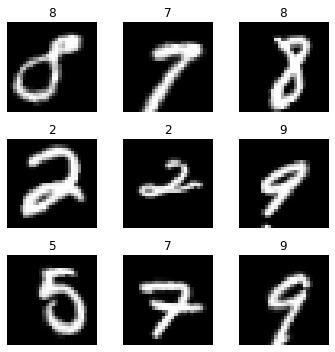

In [39]:
data.show_batch(rows=3, figsize=(5,5))

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [41]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.907843,0.640597,0.795119,07:40
1,0.472749,0.298351,0.904643,07:46
2,0.305952,0.194560,0.938095,07:53
3,0.282149,0.184807,0.940833,07:27


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


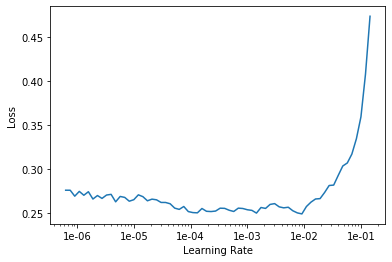

In [42]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze()

In [44]:
learn.fit_one_cycle(3, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.128522,0.098725,0.970238,14:47
1,0.075158,0.031879,0.989643,14:55
2,0.042786,0.025025,0.992143,15:01


In [0]:
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)
# output to a file
submission_df = pd.DataFrame({'ImageId': list(range(1,len(labels)+1)), 'Label': labels})
submission_df.to_csv(f'submission.csv', index=False)